# Universal noise

This notebook computes a universal noise pattern, which can be added to any image 
and missleads the open pose network 

In [1]:
%load_ext autoreload
%autoreload 2
# imports
import datetime
import logging
import os
import pathlib
import sys

import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm import tqdm

from loss_functions import multi_stage_loss
from plot_utils import gen_plot_universal_noise, plot_pose
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path
from utils import load_batch
import glob 

sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)

/home/ax/miniconda3/envs/masterThesis/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [2]:
image_path_targets = []
for file in glob.glob("../data/generated/*.xml"):
    filename, file_extension = os.path.splitext(file)
    image_path_targets.append(filename)
    
image_path_targets.reverse()
print(f'Found {len(image_path_targets)} images')

Found 29 images


In [3]:
# only use a single file for the beginning
image_path_targets = ["../data/generated/a_8_8c766163-d922-4a6a-9374-8a0abb788f41"]

In [4]:
# params 432, 368
w, h = 768, 576
TEST_CNT = 16
NOISE_WIDTH, NOISE_HEIGHT = 200, 400
image_path_targets = image_path_targets[:TEST_CNT]

image_targets = [common.read_imgfile(f'{image_path_target}.jpg', w, h) for image_path_target in image_path_targets]
image_masks = [common.read_imgfile(f'{image_path_target}_mask.png', w, h, cv2.IMREAD_GRAYSCALE) > 0 for image_path_target in image_path_targets]
image_transforms = [np.load(f'{image_path_target}_warp.npy')  for image_path_target in image_path_targets]
model = 'cmu'
log_dir = '../logs/'

resize_out_ratio = 4.0
summary_writer = tf.summary.FileWriter(
    log_dir + "uniadv_rendering_2d_warp_train/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [5]:
# the input image
sample = tf.placeholder(
    tf.float32,
    shape=(None, None, None, 3),
    name='sample'
)

# the current universal noise
universal_noise = tf.placeholder(
    tf.float32,
    shape=(None, None, None, 3),
    name='universal_noise'
)

# create a placeholder for the transform
transforms = tf.placeholder(
    tf.float32,
    shape=(None, 8),
    name='2d_transform'
)

# warp the noise 
warped_universal_noise = tf.contrib.image.transform(
    universal_noise,
    transforms,
    interpolation='NEAREST',
    output_shape=(h, w),
    name='warped_universal_noise'
)

ax_input_overwrite = tf.math.add(
    sample,
    warped_universal_noise,
    name='ax_input_overwrite'
)

In [6]:
estimator = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False, input_overwrite_tensor=ax_input_overwrite)

With input overwrite


In [7]:
summary_writer.add_graph(estimator.graph)

In [7]:
image_target = image_targets[0]

upsample_size = [int(estimator.target_size[1] / 8 * resize_out_ratio),
                 int(estimator.target_size[0] / 8 * resize_out_ratio)]
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf = estimator.persistent_sess.run(
    [estimator.tensor_output, estimator.tensor_heatMat_up,
        estimator.tensor_pafMat_up],
    feed_dict={
        # the current sample image 
        sample: [image_target],
        # the current universal noise
        universal_noise: [np.zeros((NOISE_HEIGHT, NOISE_WIDTH, 3))],
        # the current 2d warp
        transforms: [[1, 0, 0, 0, 1, 0, 0, 0]],
        # the upsample size
        estimator.upsample_size: upsample_size
    }
)

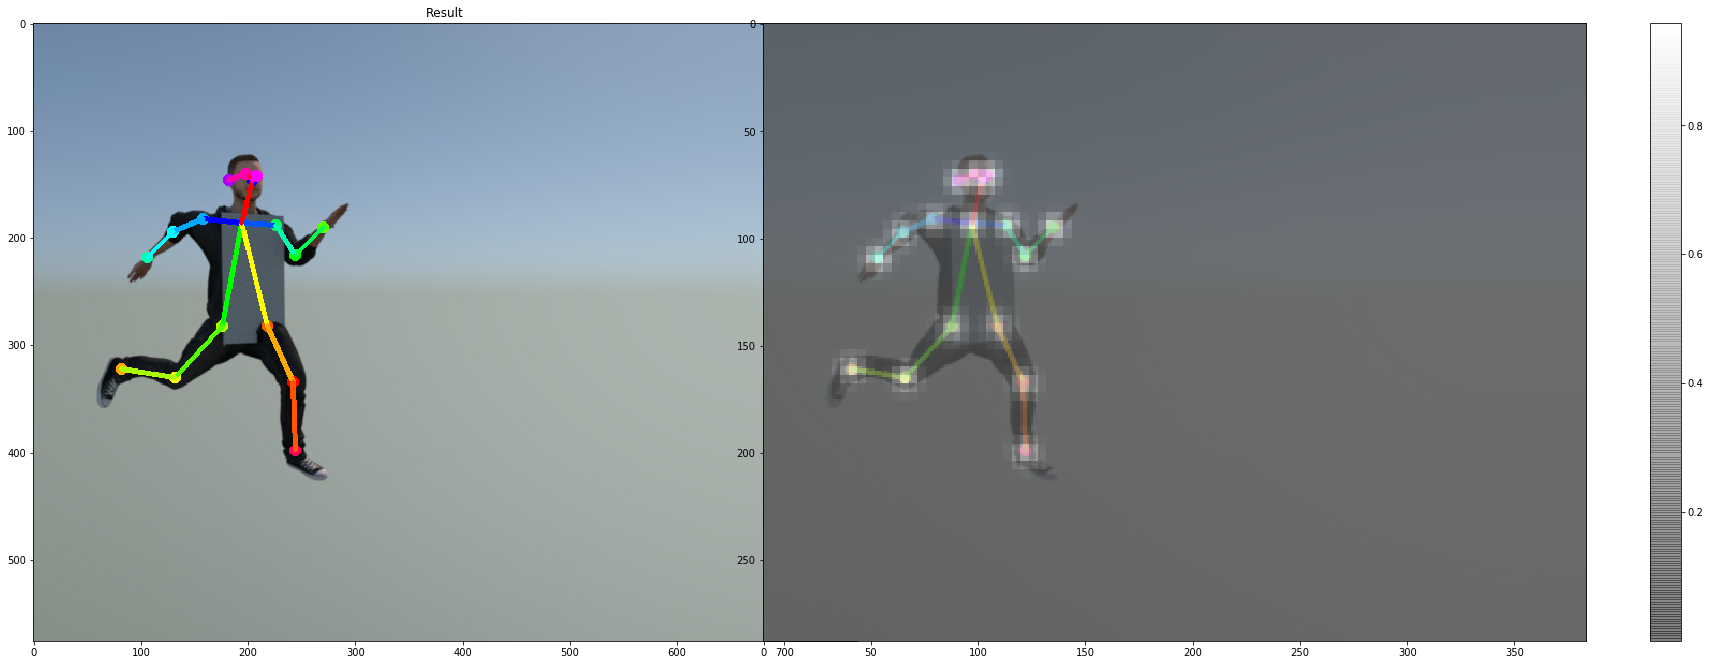

In [9]:
human_target = estimator.inference(
    image_target, resize_to_default=True, upsample_size=resize_out_ratio)
plot_pose(image_target, human_target, estimator.heatMat)

In [ ]:
plt.imshow(image_masks[0])
print(image_masks[0].shape)

In [ ]:
"""
# the input image
sample = tf.placeholder(
    tf.float32,
    shape=(None, None, None, 3),
    name='sample'
)

# the current universal noise
universal_noise = tf.placeholder(
    tf.float32,
    shape=(None, None, None, 3),
    name='universal_noise'
)

# create a placeholder for the transform
transforms = tf.placeholder(
    tf.float32,
    shape=(None, None),
    name='2d_transform'
)

# warp the noise 
warped_universal_noise = tf.contrib.image.transform(
    universal_noise,
    transforms,
    interpolation='NEAREST',
    output_shape=(h, w),
    name='warped_universal_noise'
)

ax_test = tf.math.add(
    sample,
    warped_universal_noise,

)

with tf.Session() as sess:
    universal_noise_np = np.random.randint(255, size=(NOISE_HEIGHT, NOISE_WIDTH, 3), dtype=np.uint8)
    no_transform = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
    current_transform = image_transforms[0]
    #current_transform = no_transform
    a0, a1, a2, b0, b1, b2, c0, c1 = current_transform
    M = np.array([
        [a0, a1, a2],
        [b0, b1, b2],
        [c0, c1, 1.0],
    ], dtype=np.float32)

    output = sess.run(
        [ax_test],
            feed_dict={
                sample: [image_target],
                universal_noise: [universal_noise_np],
                transforms: [current_transform],
            }
        )[0]


print(M)
warped = cv2.warpPerspective(universal_noise_np, M, (w, h))
fig = plt.figure(figsize=(25, 50))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.clip(image_target + warped, 0, 255) / 255.0)
ax.set_title('openCV', fontdict={'fontsize': 14, 'fontweight': 'medium'})



ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.clip(output[0], 0, 255) / 255.0)
ax.set_title('Tensorflow', fontdict={'fontsize': 14, 'fontweight': 'medium'})

"""

In [17]:
def multi_stage_loss_with_2D_warp(estimator, target_heat, target_paf, universal_noise):
    losses_per_stage = []
    stage = 6
    # compute loss per stage
    
    paf_op = estimator.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L1/BiasAdd').outputs[0]
    heat_op = estimator.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L2/BiasAdd').outputs[0]

    # compute the loss for every channel
    loss_paf = tf.nn.l2_loss(tf.concat(paf_op, axis=-1) - tf.concat(target_paf, axis=-1), name='AX_loss_l1_stage%d_' % (stage))
    loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage%d_' % (stage))

    # combined loss form every stage
    total_loss = tf.reduce_sum([loss_paf, loss_heat])
    summary = tf.summary.scalar('total_loss', total_loss)

    grad = tf.gradients(total_loss, universal_noise)[0]
    return grad, summary,

def get_universal_noise(estimator, image_target, universal_noise_filename, mask, current_transform):
    EPS = 5000
    STEPS = 100
    BATCH_SIZE = 16
    
    upsample_size = [int(estimator.target_size[1] / 8 * resize_out_ratio),
                 int(estimator.target_size[0] / 8 * resize_out_ratio)]
    
    # get all outputs as np matrix
    target_np_heat = np.zeros((1, 72,96, 19))
    target_np_paf = np.zeros((1, 72,96, 38))


    # where does the current batch start
    training_stats = {
        'image_index': 0,
        'universal_noise': np.zeros((NOISE_HEIGHT, NOISE_WIDTH, 3)),
        'file_name': f'../snapshots/{universal_noise_filename}.npy'
    }
    
    target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
    target_paf = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 38))
    grad_func, loss_func = multi_stage_loss_with_2D_warp(estimator, target_heat, target_paf, universal_noise)
    
    summary_writer.add_graph(estimator.graph)

    ### ================= TRAINING ================= ###

    for i in tqdm(range(STEPS)):
        feed_dict = {
            # the target heatmap
            target_heat: target_np_heat,
            # the target paf
            target_paf: target_np_paf,
            # the current sample image 
            sample: [image_target],
            # the current universal noise
            universal_noise: [training_stats['universal_noise']],
            # the current 2d warp
            transforms: [current_transform],
            # the upsample size
            estimator.upsample_size: upsample_size
        }

        
        gradient, gn_summ = estimator.persistent_sess.run(
            [grad_func, loss_func],
            feed_dict=feed_dict
        )
        summary_writer.add_summary(gn_summ, training_stats['image_index'])

        if i % 25 == 0:
            # save universal noise
            np.save(training_stats['file_name'], training_stats['universal_noise'])

        ### ================= UPDATE STEP ================= ###
        #adv_image = adv_image - EPS * np.sign(gradient[0])
        scaled_gradient = (EPS * gradient[0])
        training_stats['universal_noise'] = training_stats['universal_noise'] - scaled_gradient
        training_stats['universal_noise'] = np.clip(training_stats['universal_noise'], 0, 255)

        training_stats['image_index'] += 1


    summary_writer.flush()
    return training_stats['universal_noise']

In [18]:
universal_noises = []
universal_noise_filenames = [f'{image_path_target}_uni_noise' for image_path_target in image_path_targets]
for (i, image_target) in enumerate(image_targets):
    universal_noises.append(
        get_universal_noise(estimator, image_target, universal_noise_filenames[i], image_masks[i], image_transforms[0]))

100%|██████████| 100/100 [35:19<00:00, 21.20s/it]


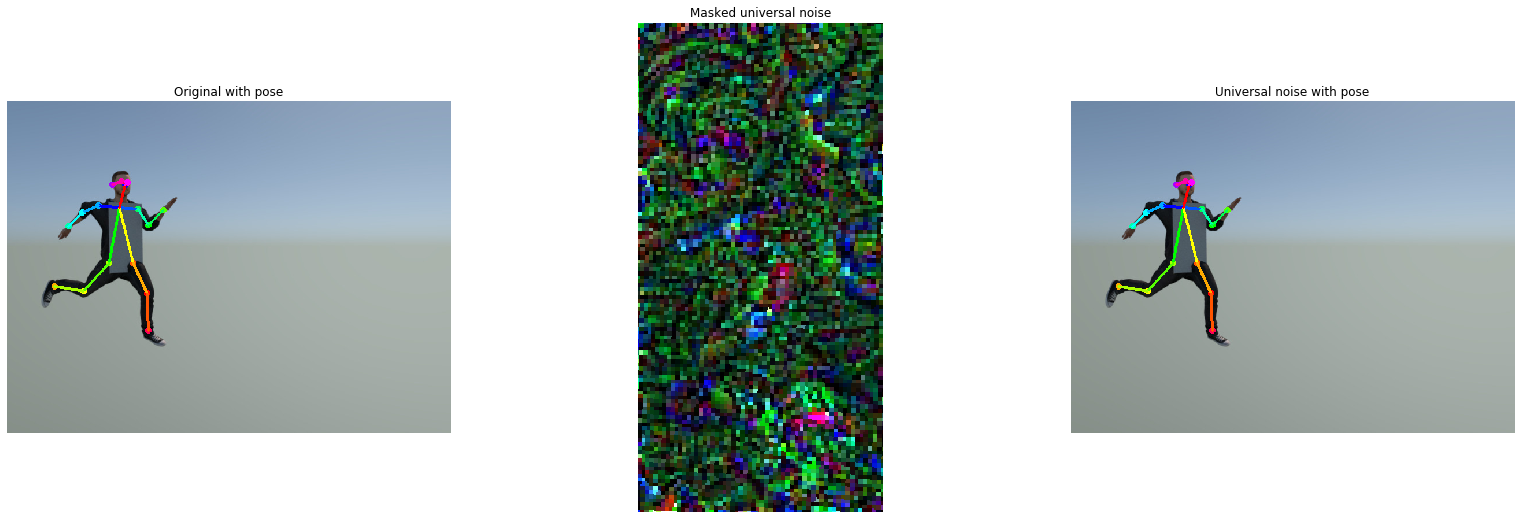

In [22]:
# Plot attributions
%matplotlib inline
n_cols = 3
n_rows = len(image_targets)
fig_scale = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(
    3*n_cols*fig_scale, 3*n_rows*fig_scale))

plot_cnt = 0

for i, xi in enumerate(image_targets):
    detections = estimator.inference(xi, resize_to_default=True, upsample_size=resize_out_ratio)
    detections_result = TfPoseEstimator.draw_humans(xi, detections, imgcopy=True)
    
    ax = axes.flatten()[plot_cnt]
    ax.imshow(cv2.cvtColor(detections_result, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Original with pose')
    ax.axis('off')
    plot_cnt += 1
    
    universal_noise = universal_noises[i]
    
    ax = axes.flatten()[plot_cnt]
    ax.imshow(universal_noise / 255.0)
    ax.set_title(f'Masked universal noise')
    ax.axis('off')
    plot_cnt += 1
    
    detections = estimator.inference(
        xi, 
        resize_to_default=True, 
        upsample_size=resize_out_ratio, 
        transforms=[image_transforms[i]],
        universal_noise=[universal_noise]
    )
    detections_result = TfPoseEstimator.draw_humans(xi, detections, imgcopy=True)
    
    ax = axes.flatten()[plot_cnt]
    ax.imshow(cv2.cvtColor(detections_result, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Universal noise with pose')
    ax.axis('off')
    plot_cnt += 1
    
    
    
    